In [1]:
from matplotlib import pyplot as plt
import random
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
# a=np.array([3,7.6]) #correct angle to x axis=68.5 degrees
# #usage of ::-1 operator
# m_false=np.arctan2(*a)
# m_correct=np.arctan2(*a[::-1])
# #create basic scatterplot
# plt.plot(a[0],a[1], 'o', label="x=a[0] | y=a[1]") #x=3 | y=7.6
# # #########################
# # #np.arctan2 
# # numpy.arctan2(x1, x2,[...]
# # Parameters:
              
# # x1
# # array_like, real-valued
# # y-coordinates.

# # x2array_like, real-valued
# # x-coordinates. 
# # ##########################
# plt.axline((0, 0), slope=np.tan(m_false), linewidth=0.5, color='r', label = r'angle in degrees = {}'.format(round(np.rad2deg(m_false),2)))
# plt.axline((0, 0), slope=np.tan(m_correct), linewidth=0.5, color='g', label = r'angle in degrees = {}'.format(round(np.rad2deg(m_correct),2)))
# #plt.plot(a[1][0], m*a[1][0]axline((0, 0), (1, 1), linewidth=4, color='r')+0, '-r', label='y=2x+1')
# plt.legend()
# #add linear regression line to scatterplot 
# #plt.plot(a[1][0], m*a[1][0]+0)
# ax = plt.gca()
# ax.set_xlim([0, 8])
# ax.set_ylim([0, 8])

# Helping functions

In [3]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))
def unit_vector(angle):
    return np.array([np.cos(angle), np.sin(angle)])
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def render_ep (boat_plot, index, tw_vec=0, sail_angle=0, target=False):
    from matplotlib import pyplot as plt
    #true wind vector
    #plt.figure(figsize=(10, 6), dpi=200)
    #define plots
    fig, ax = plt.subplots()

    #define coordinates and directions
    if tw_vec.all!=0:
        x = 1
        y = 0.02
        u = tw_vec[0]
        v = tw_vec[1]
    #sail angle   
    if sail_angle.all!=0:
        x1 = 5        
        u1 = sail_angle[0]
        v1 = sail_angle[1]
        sail=ax.quiver(x1, y, u1, v1, color='blue')
        ax.plot([], [], color='blue', label="boat heading")

    #create quiver plot
    wind=ax.quiver(x, y, u, v, color='black')
    ax.plot([], [], color='black', label="wind")

    #starting point
    #target point
    #PENDING: spline connecting each point
    
    boat_plot=np.split(boat_plot,len(boat_plot)/2)
    #boat_plot=np.split(boat_plot,len(boat_plot)/2)
    boat_plot=np.array(boat_plot)
    #for plotting starting point with different symbol
    start=boat_plot[0]
    #for plotting ending point with different symbol
    end=boat_plot[-1]
    #keeping all in between points
    boat_plot=boat_plot[1:-1]
    #boat_plot=boat_plot[0::50]
    # Scatter plot
    #light blue -> darker blue 
    target_plot=env.target_position
    x=boat_plot[:, 0]
    y=boat_plot[:, 1]
    weights = np.arange(1,boat_plot[:, 1].shape[0]+1)
    
    points_size=np.linspace(1,15,len(boat_plot))
    
    #plt.scatter(figsize=(5, 5))
    plt.scatter(start[0], start[1], marker="$A$",  c='green', s=100)
    plt.scatter(end[0], end[1], marker="$B$",  c='red', s=100)
    plt.scatter(x, y, c=weights, cmap='coolwarm' ,s=points_size)
    plt.title(f"{index}-th episode")
    if target==True:
        plt.scatter(target_plot[0], target_plot[1], marker="$T$",  c='green', s=100)
    # Display the plot
    #from matplotlib.pyplot import figure

    ax.legend()
    
    #plt.xlim(2*min(x),2*max(x))
    #plt.ylim(2*min(y),2*max(y))
    #plt.xlim(11,15)
    #plt.ylim(0,0.5)
    plt.show()




# Environment

In [57]:
import numpy as np

class SailBoatEnvironment:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.9):
        #to heading einai katheto sto sail, ara an to sail einai stis 90 moires to global x axis, to heading einai stis 0 moires, koitaei pros to +apeiro
        #self.sail_configs = np.linspace(np.pi/4, 3*np.pi/4, 5) #angles (in radians) of sail to x global axis
        #megalyleteri elergtheria gia to sail angle
        self.sail_configs = np.linspace(0, 2*np.pi, 10)
        self.tw_possible_angles=np.linspace(0, np.pi, 8) #angles (in radians) of true wind direction to x global axis
                

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def reset(self):
        #returns
        #i)boat position: starting point of boat        
        #ii)random wind direction, epistrefei to index sto self.tw_possible_angles
        self.step_num=0     
        #random true wind direction
        self.true_wind_direction = np.random.choice(self.tw_possible_angles)
        #fixed true wind direction
        #self.true_wind_direction = self.tw_possible_angles[1]
        self.boat_position = np.array([2, 3])
        #fixed target position
        #self.target_position = np.array([12,15]) 
        #random target position
        self.target_position = np.random.randint(90, size=(1, 2))
        self.tw_velocity_vector=unit_vector(self.true_wind_direction)/2
        #self.boat_velocity = self.tw_velocity_vector
        #print(f"{self.step_num}: Wind Velocity = {self.tw_velocity_vector}")
        #print(self.boat_position)
        return self.boat_position, np.where(self.true_wind_direction==self.tw_possible_angles)[0][0]
        
        
        


    def step(self, action):

        sail_config = action
        self.heading=sail_config #heading = h gwnia twn paniwn se sxesh me ton global x aksona
        #print(f"heading -> {self.heading}")
        #sail_force = sail_config * np.sin(self.true_wind_direction - np.arctan2(*self.boat_position[::-1]))
        #sail_force = sail_config * np.sin(self.true_wind_direction - self.heading)
        #print(f"gwnia: -> {np.sin(self.true_wind_direction - self.heading)} -> sail force={sail_force}")
        #print(f"gwnia? {np.arctan2(*self.boat_position[::-1])}")
        #boat_velocity = np.array([np.cos(self.true_wind_direction), np.sin(self.true_wind_direction)]) * sail_force 
        #scale = 1.3 # for debugging only
        self.heading_vector=unit_vector(sail_config) #unit vector heading
        nominator = self.heading_vector @ self.tw_velocity_vector
        denominator= self.heading_vector @ self.heading_vector
        self.boat_velocity = self.heading_vector*nominator*denominator
        self.boat_position_old=self.boat_position
        self.boat_position = self.boat_position + self.boat_velocity

        
        self.step_num+=1
        

        
        done = False
        truncated = False
        reward = -0.5


        distance_to_target = np.linalg.norm(self.boat_position - self.target_position)
        if distance_to_target < 1.75:
            print(f"Eftasa me distance_to_target:{distance_to_target}")
            done = True
            reward = 100
        
        #me to teleytaio or den paei me opisthen
        if self.step_num >= 250 or not np.any(np.round(self.boat_velocity,2)) :#or nominator*denominator<0:
            truncated = True

#         print(f"{self.step_num}: heading_vector={np.round(self.heading_vector,2)} | V={np.round(self.boat_velocity,2)} /-/ P={np.round(self.boat_position,2)}\
#         /-/ paragontas={round(nominator*denominator,2)} /-/ Sail Angle to X = {np.rad2deg(np.pi/2+sail_config)} moires\
#         /-/ R={reward} /-/ DF: {np.round(np.linalg.norm(self.boat_position_old-self.boat_position),2)}")


        return self.boat_position, reward, done, truncated, self.step_num

env=SailBoatEnvironment()
#current state = true wind direction + angle of boat to target wrt x axis
#prwto einai gia true wind angles
a=len(env.tw_possible_angles)
#deytero ola ta possible actions
b=len(env.sail_configs)

In [51]:
q_table = np.random.uniform(low=-4, high=0, size=(a,b))

# Train Q table

In [59]:
EPISODES=5_000
tw_direction=[]
boat_plot=[]
boat_plot_all_ep=[] #stores all episodes' movement
action_recorder=[]
action_recorder_all_ep=[] #stores all episodes' actions
dones=np.zeros(EPISODES)

for i in range(EPISODES):
    boat_plot=[]
    action_recorder=[]
    reset_state=env.reset()
    boat_pos=reset_state[0]
    current_state=reset_state[1]
    tw_direction=np.append(tw_direction,current_state)
    done=False
    truncated=False
    step_num=0
    boat_plot=np.append(boat_plot,np.array(boat_pos))
    while not done: # or not truncated:

        if i < 300:
        #         # Get random action
            sail_conf_index = random.sample(range(0,len(env.sail_configs)),1)[0]
        else:
        #         # Get "best" action
            sail_conf_index=np.argmax(q_table[current_state])
            


        #sail_conf_index=1
        action=env.sail_configs[sail_conf_index]
        
        #action=np.deg2rad(180+55)
        action_recorder=np.append(action_recorder,np.array(action))

        

        boat_pos, reward, done, truncated, step_num = env.step(action)
        
        #print(f"step:{step_num}: boat position={boat_pos}")
        
        

        
        boat_plot=np.append(boat_plot,np.array(boat_pos))
        
        

        #Training

        Q_max=np.max(q_table[(current_state)])

        q_current=q_table[current_state,sail_conf_index]

        new_q=(1-env.alpha)*q_current+env.alpha*(reward+env.gamma*Q_max)

        q_table[current_state,sail_conf_index]=new_q
        
        #Comment above block for evaluating
        
        #print(new_q)
        if done==True:
            #print(f"{i}-th ep -> Egina done sto {step_num}-th step sth thesi:{np.round(boat_pos,2)}.")
            dones[i]=1
            break

        if truncated==True:
            #print(f"{i}-th ep -> Egina truncated sth thesi:{np.round(boat_pos,2)}")
            #print(f"{i}-th ep -> new_q={new_q}")
            break
        #apo th stigmh poy se kathe epeisodio o anemos menei statheros (allazei mono otan treksei h reset()) den yparxei logos gia thn epomenh grammh
        
        #current_state=new_state


    #print(i)
    boat_plot_all_ep.append(boat_plot)
    action_recorder_all_ep.append(action_recorder)
    
#     if i%800==0:
#         print(f"{i}-th ep -> steps: {step_num}")
    
#plot last episode

#vec=unit_vector(env.tw_possible_angles[int(tw_direction[i])])
#render_ep(boat_plot_all_ep[i],i, vec, np.array([0,0]), True)

#debugging only: constant sail angle
#render_ep(boat_plot_all_ep[i],i, vec, unit_vector(action), True)

Eftasa me distance_to_target:1.5780325422629127
Eftasa me distance_to_target:1.742639332484569
Eftasa me distance_to_target:1.646590238769711
Eftasa me distance_to_target:0.5
Eftasa me distance_to_target:1.6194806610737587
Eftasa me distance_to_target:1.4142135623730951
Eftasa me distance_to_target:1.1112604669781572
Eftasa me distance_to_target:1.6325691130654327
Eftasa me distance_to_target:1.4142135623730951
Eftasa me distance_to_target:1.7300233513664611
Eftasa me distance_to_target:1.5
Eftasa me distance_to_target:1.4142135623730951
Eftasa me distance_to_target:1.4142135623730951
Eftasa me distance_to_target:1.3379924542450823
Eftasa me distance_to_target:1.337855731219134
Eftasa me distance_to_target:1.423485487858613
Eftasa me distance_to_target:1.7094312639388625
Eftasa me distance_to_target:1.4142135623730951
Eftasa me distance_to_target:1.5
Eftasa me distance_to_target:1.7477162360213332
Eftasa me distance_to_target:1.4142135623730951
Eftasa me distance_to_target:1.5192284506

In [46]:
sail_conf_index

5

In [49]:
action_recorder_all_ep[0]

array([4.1887902 , 3.4906585 , 2.0943951 , 5.58505361])

In [24]:
q_table[current_state]

array([-3.70395283, -3.71080382, -3.71046695, -3.7122344 , -3.70864663,
       -3.70881554, -3.71413455, -3.70925872, -3.70657813, -3.70752814])

In [58]:
q_table

array([[-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
       [-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
       [-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
       [-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
       [-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
       [-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
       [-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.],
       [-5., -5., -5., -5., -5., -5., -5., -5., -5., -5.]])

In [53]:
dones
#Count number of successful episodes
num_successful_episodes=np.count_nonzero(dones == 1)
#Index of successful episodes
successful_indices=np.where(dones==1)[0]
print(f"posa epeisodia teleiwsa: {num_successful_episodes} apo ta {EPISODES} \ndhladh to {round(num_successful_episodes/EPISODES,2)*100}%")

posa epeisodia teleiwsa: 116 apo ta 5000 
dhladh to 2.0%


In [27]:
successful_indices[:]

array([], dtype=int64)

# Plot episodes that ended successfully

In [28]:
for i in successful_indices[:]:
    vec=unit_vector(env.tw_possible_angles[int(tw_direction[i])])
    render_ep(boat_plot_all_ep[i],i, vec, np.array([0,0]), True)

# Plot episodes that ended successfully with different wind setting

In [54]:
#Gia pio setting aera ginetai done
tw_direction[successful_indices]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

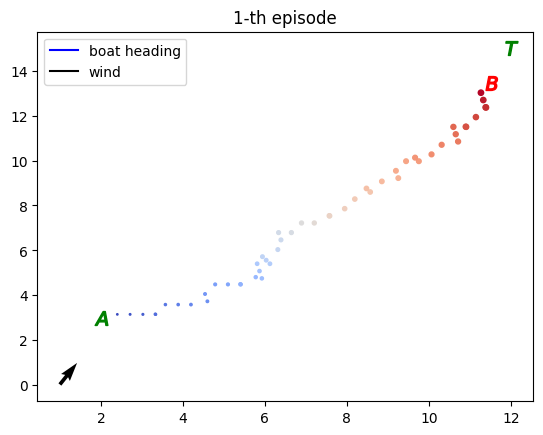

In [55]:
for i in np.unique(tw_direction[successful_indices], return_index=True)[1]:
    vec=unit_vector(env.tw_possible_angles[int(tw_direction[successful_indices[i]])])    
    render_ep(boat_plot_all_ep[successful_indices[i]],successful_indices[i], vec, np.array([0,0]), True)

# Plot random episodes 

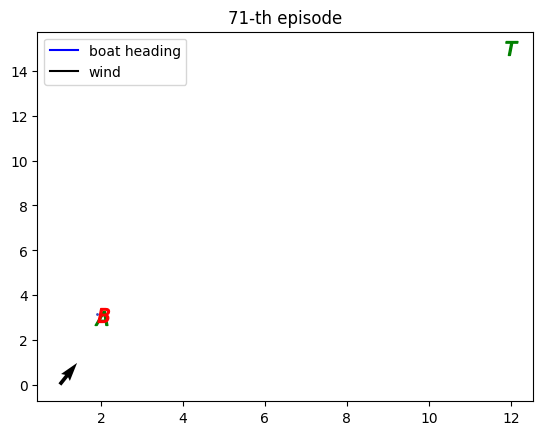

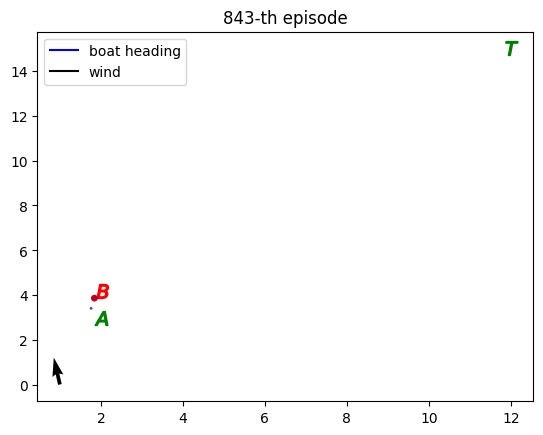

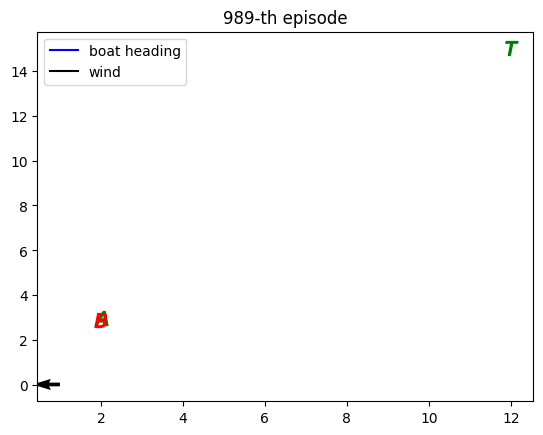

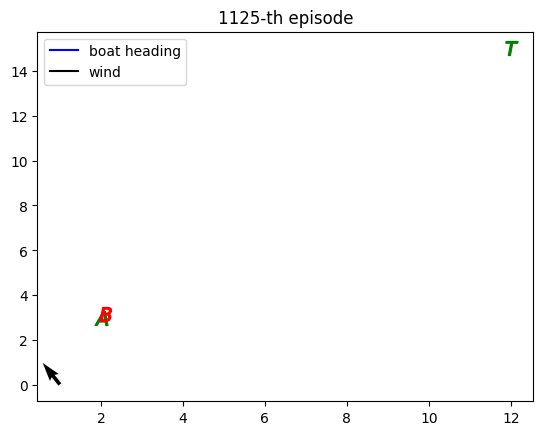

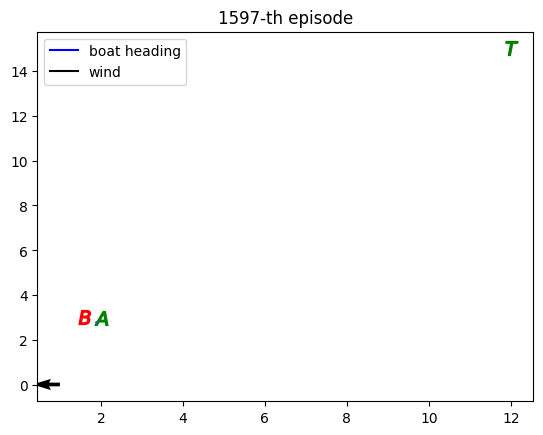

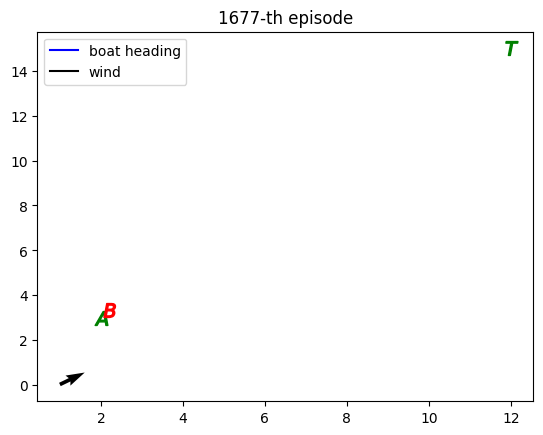

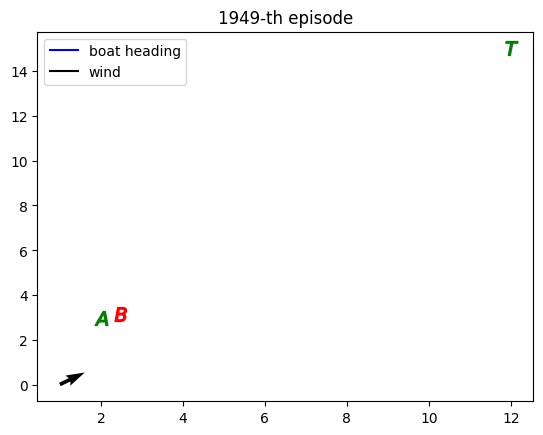

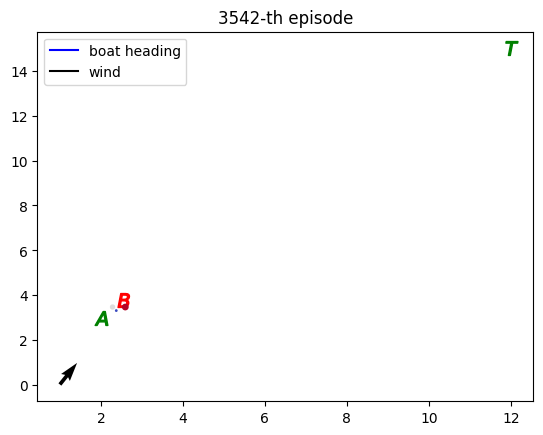

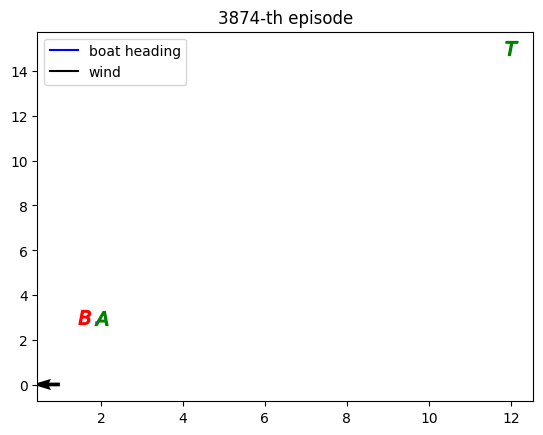

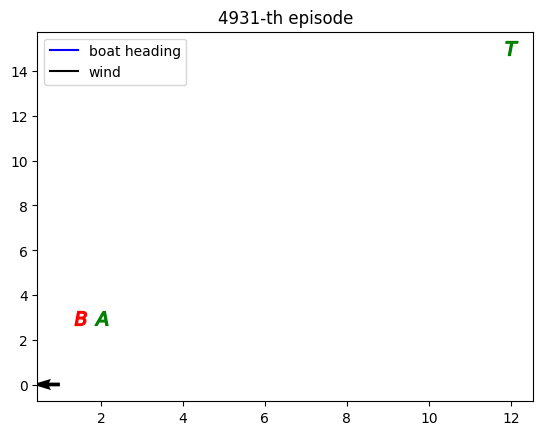

In [31]:
for i in sorted(random.sample(range(0,EPISODES),10)):
    vec=unit_vector(env.tw_possible_angles[int(tw_direction[i])])
    render_ep(boat_plot_all_ep[i],i, vec, np.array([0,0]), True)

# Plot random episodes with different wind setting

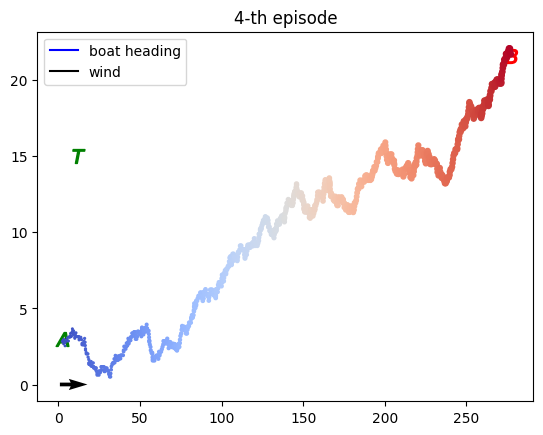

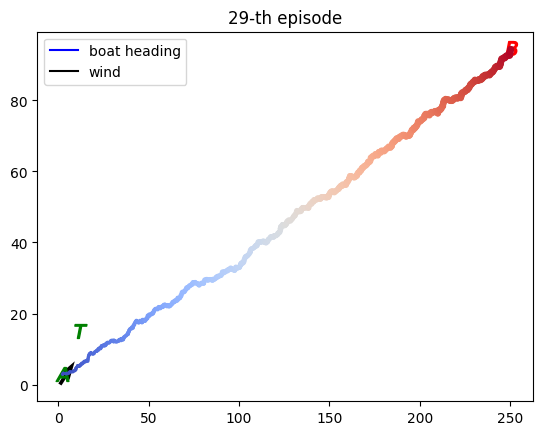

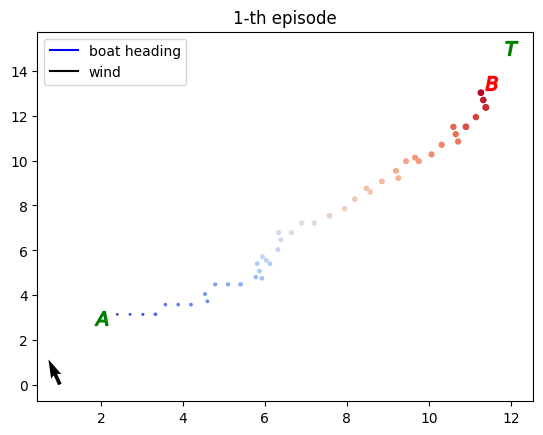

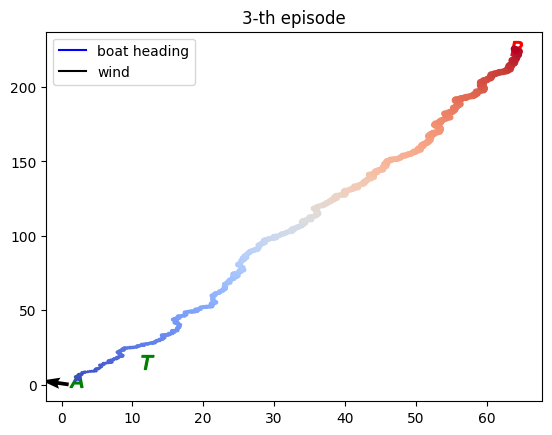

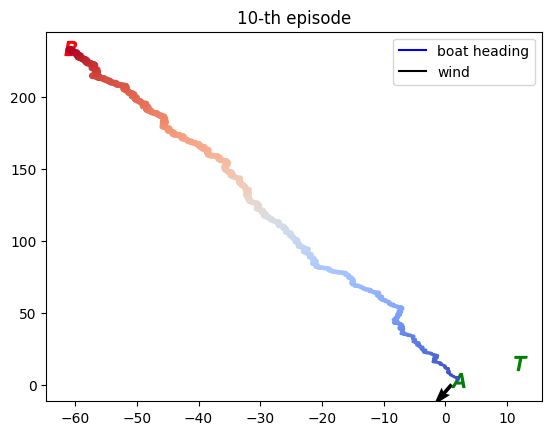

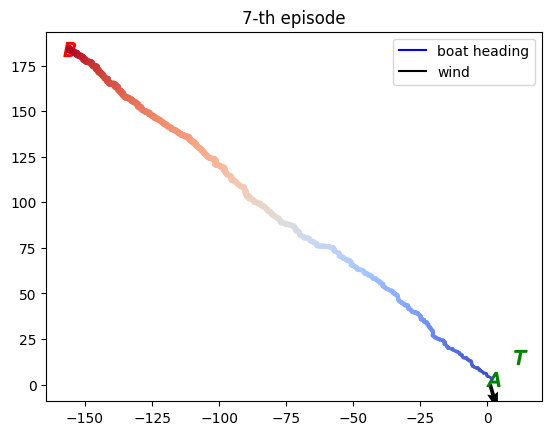

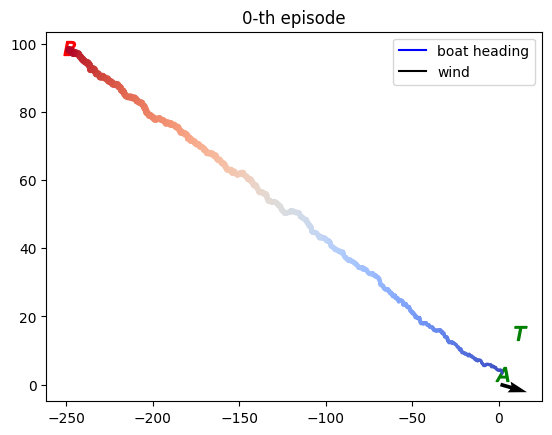

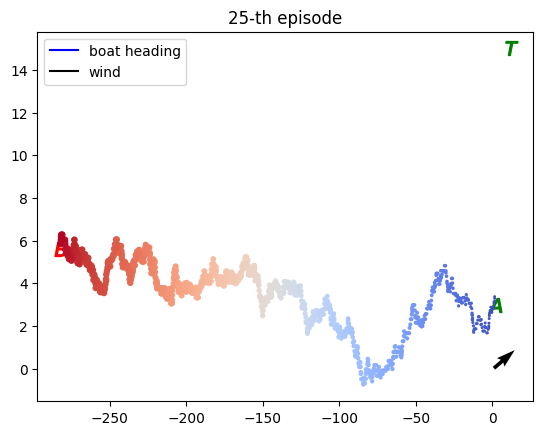

In [56]:
for i in np.unique(tw_direction,return_index=True)[1]:
    vec=unit_vector(tw_direction[i])
    render_ep(boat_plot_all_ep[i],i, vec, np.array([0,0]), True)